# POP 
Proceso de Optimización de Pronósticos?

El siguiente notebook permite Optimizar los pronósticos de Subdir-GE3 para seleccionar el modelo más adecuado.

El modelo adecuado será aquel que minimicé el MAPE Deacero a nivel SKU BU - ej. **$min(MAPE_{Deacero})$**  Seleccionado entre los siguientes Modelos

* PVO
* BayesianRidge	
* GradientBoostingRegressor	
* KNeighborsRegressor	
* LGBMRegressor	
* RandomForestRegressor
* Ridge	
* SVR
* XGBRegressor
* Demmand Management 

In [142]:
import pandas as pd 
import numpy as np 
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
import itertools

pd.set_option('display.max_columns', None)

# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

# Crear date_today como el primer día del mes actual
now = datetime.now() - relativedelta(days= 3)

date_today = datetime(now.year, now.month, 1)

# Crear date_last_6m como seis meses antes de date_today
date_last_6m = date_today - relativedelta(months=5)

# Crear date_forecas como seis meses después de date_today
date_forecas = date_today + relativedelta(months=6)

# Mostrar las fechas
print("date_today:", date_today.strftime("%Y-%m-%d"))

print("date_last_6m:", date_last_6m.strftime("%Y-%m-%d"))

print("date_forecas:", date_forecas.strftime("%Y-%m-%d"))

date_today: 2025-08-01
date_last_6m: 2025-03-01
date_forecas: 2026-02-01


In [143]:
query_str = """
SELECT 
  `FECHA_EJECUCION`,
  `FECHA`,
  `COV%`,
  `MAPE%`,
  `MODEL`,
  `NOMBREGRUPOESTADISTICO3`,
  `NOMBRESUBDIRECCION`,
  `Y_HIST`,
  `Y_PREDICCION`,
  `Y_PRONOSTICOS`,
  `Y_TEST`
FROM demanda-prj-dev.pronosticos.forecast_table
WHERE FECHA_EJECUCION = (
  SELECT MAX(FECHA_EJECUCION)
  FROM demanda-prj-dev.pronosticos.forecast_table
  )
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

forecast = query.to_dataframe(create_bqstorage_client=True)

forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)

forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)

forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)

forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

print(forecast.FECHA.value_counts().sort_index().tail(5))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


FECHA
2025-10-01    4184
2025-11-01    4184
2025-12-01    4184
2026-01-01    4124
2026-02-01    3954
Name: count, dtype: int64


In [ ]:
query_str = """
SELECT 
  `FECHA_EJECUCION`,
  `FECHA`,
  `COV%`,
  `MAPE%`,
  `MODEL`,
  `NOMBREGRUPOESTADISTICO3`,
  `NOMBRESUBDIRECCION`,
  `Y_HIST`,
  `Y_PREDICCION`,
  `Y_PRONOSTICOS`,
  `Y_TEST`
FROM demanda-prj-dev.pronosticos.forecast_table
WHERE FECHA_EJECUCION = (
  SELECT MAX(FECHA_EJECUCION)
  FROM demanda-prj-dev.pronosticos.forecast_table
  )
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

forecast = query.to_dataframe(create_bqstorage_client=True)

forecast.sort_index(inplace=True, ascending=True)

forecast["Y_HIST"] = forecast["Y_HIST"].astype(float)

forecast["Y_PREDICCION"] = forecast["Y_PREDICCION"].astype(float)

forecast["Y_PRONOSTICOS"] = forecast["Y_PRONOSTICOS"].astype(float)

forecast["Y_TEST"] = forecast["Y_TEST"].astype(float)

print(forecast.FECHA.value_counts().sort_index().tail(5))

forecast.groupby("FECHA").apply(lambda x: x.isna().sum().div(8))

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


FECHA
2025-10-01    4184
2025-11-01    4184
2025-12-01    4184
2026-01-01    4124
2026-02-01    3954
Name: count, dtype: int64


C:\Users\adojeda\AppData\Local\Temp\ipykernel_3924\2994330214.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  forecast.groupby("FECHA").apply(lambda x: x.isna().sum().div(8))


,FECHA_EJECUCION,FECHA,COV%,MAPE%,MODEL,NOMBREGRUPOESTADISTICO3,NOMBRESUBDIRECCION,Y_HIST,Y_PREDICCION,Y_PRONOSTICOS,Y_TEST
FECHA,,,,,,,,,,,
2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,7.50,7.50,7.50
2024-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,28.75,28.75,28.75
2024-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,523.00,523.00,523.00
2024-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,523.00,523.00,523.00
2024-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,523.00,523.00,523.00
2024-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,523.00,523.00,523.00
2025-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,515.50,523.00,515.50
2025-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,494.25,523.00,494.25
2025-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,523.00,0.00


In [151]:
forecast.groupby(["FECHA","MODEL"]).agg({ "Y_PRONOSTICOS":"sum"}).unstack(-1).tail(10)

Y_PRONOSTICOS                                                \
MODEL       BayesianRidge GradientBoostingRegressor KNeighborsRegressor   
FECHA                                                                     
2025-05-01       0.000000                  0.000000            0.000000   
2025-06-01       0.000000                  0.000000            0.000000   
2025-07-01     205.543602                100.269641          152.664713   
2025-08-01    1764.834536               1760.012064          851.350657   
2025-09-01  209025.897200             208789.176287       210984.846911   
2025-10-01  205537.908276             202583.779725       209265.670213   
2025-11-01  201814.975948             201564.251776       208943.848041   
2025-12-01  195184.773621             195426.589390       201285.974609   
2026-01-01  195038.258914             194274.228245       198383.152836   
2026-02-01  182632.931089             178649.341824       182776.722394   

                                                                               \
MODEL       LGBMRegressor RandomForestRegressor          Ridge            SVR   
FECHA                                                                           
2025-05-01       0.000000              0.000000       0.000000       0.000000   
2025-06-01       0.000000              0.000000       0.000000       0.000000   
2025-07-01     307.522013            105.019647     208.968517     150.366341   
2025-08-01    1046.495283            916.099410    1769.484999     927.511224   
2025-09-01  187267.122231         206128.177004  209151.199828  205786.244758   
2025-10-01  200279.448510         201945.472640  201290.538530  205902.641254   
2025-11-01  194600.998096         198893.975058  201365.464919  203006.676880   
2025-12-01  190376.918351         195658.135127  195424.894524  201856.189974   
2026-01-01  196595.794581         194302.280570  194401.599669  204154.624683   
2026-02-01  190887.569808         184741.652594  178752.449032  198944.678517   

                           
MODEL        XGBRegressor  
FECHA                      
2025-05-01       0.000000  
2025-06-01       0.000000  
2025-07-01     192.950328  
2025-08-01    1383.500919  
2025-09-01  207723.081757  
2025-10-01  201117.863881  
2025-11-01  198015.271109  
2025-12-01  191285.306162  
2026-01-01  192345.682709  
2026-02-01  176268.962093

In [139]:
# declaramos las credenciales al entorno de desarollo
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "..\\..\\bd\\0_docs\\datahub-deacero-adojeda.json"

query_str = """
SELECT
FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%B.%Y', mes_anio)) AS FECHA,
nom_grupo AS NombreGrupo,
nom_direccion AS NombreDireccion,
nom_subdireccion AS NombreSubdireccion,
nom_grupo_estadistico1 AS GE1,
nom_grupo_estadistico2 AS GE2,
nom_grupo_estadistico3 AS GE3,
sum(toneladas_pvo) AS PVO,
sum(toneladas_facturadas) AS FACT,
#sum(toneladas_mejor_pronostico) AS MAX,
sum(toneladas_plan_ventas) AS PV
FROM `datahub-deacero.mart_comercial.comercial` 
WHERE 
EXTRACT(YEAR FROM fecha) >= 2025
AND
EXTRACT(YEAR FROM fecha) < 2026
AND
nom_direccion NOT IN  ('FILIALES') --> lo quité de la consulta duplica SUBDIRG3
AND
nom_subdireccion NOT IN  ('SERVICIOS LOGISTICOS DAL USA') --> lo quité de la consulta duplica SUBDIRG3
-- Descartamos los siguientes campos
#AND
#nom_grupo NOT IN ('EMPRESAS RELACIONADAS','TRASPASOS E INTEREMPRESAS')
#AND
#nom_direccion NOT IN ('EXPORTACIÓN ALAMBRES')
#AND
#nom_subdireccion NOT IN ('EXCEDENTES ACEROS','EXCEDENTES ALAMBRES','RESTO ALAMBRES','RESTO INGETEK')
#AND
#nom_grupo_estadistico1 NOT IN ('CHATARRA','DEACERO POWER','INTERNAS PRODUCCION ','LOGÍSTICA','PALANQUILLA','SEGUNDAS')
#AND
#nom_grupo_estadistico2 NOT IN ('SEGUNDAS / EXCEDENTES','CHQ')
#AND
#nom_grupo_estadistico3 NOT IN ('DESPERDICIO','ALAMBRON SEGUNDAS','ALAMBRON EXCEDENTES','ALAMBRON TERCEROS','ALAMBRON OTROS','DERECHO DE VIA','PILOTES','PISO','POLIZAS')
-- Necesitamos que la informacion no sea nula
AND nom_grupo IS NOT NULL
AND nom_direccion IS NOT NULL
AND nom_subdireccion IS NOT NULL
AND nom_grupo_estadistico1 IS NOT NULL
AND nom_grupo_estadistico2 IS NOT NULL
AND nom_grupo_estadistico3 IS NOT NULL
AND  mes_anio IS NOT NULL
GROUP BY 1,2,3,4,5,6,7
ORDER BY 1,2,3,4,5,6,7
"""

client = bigquery.Client(project="demanda-prj-dev")

consulta = query_str

query = client.query(consulta)

pv = query.to_dataframe(create_bqstorage_client=True)

pv.sort_index(inplace=True, ascending=True)

pv["PVO"] = pv["PVO"].astype(float)

pv["PV"] = pv["PV"].astype(float)

pv["FACT"] = pv["FACT"].astype(float).fillna(0)

#pv["MAX"] = pv["MAX"].astype(float)

#pv = pv[pv["valid_ton"] > 0]
pv["id"] = pv['NombreGrupo'] + "_" + pv['NombreDireccion'] + "_" + pv['NombreSubdireccion'] + "_" + pv['GE1'] + "_" + pv['GE2'] + "_" + pv['GE3']

# Suponiendo que ya tienes tu DataFrame llamado df
# Ejemplo de columnas: FECHA, SUBDIR, GE3, VALOR

# Obtener todos los valores únicos de cada columna clave
fechas = pv['FECHA'].unique()
id = pv['id'].unique()

# Generar todas las combinaciones posibles
combinaciones = pd.DataFrame(list(itertools.product(fechas, id)), columns=['FECHA',"id"])
for i, col  in enumerate(["NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"]):
    print(i, col)
    combinaciones[col] = combinaciones["id"].str.split("_").apply(lambda x:x[i])

# Unir con el DataFrame original
df_completo = pd.merge(combinaciones, pv, on=["FECHA","id","NombreGrupo", "NombreDireccion", "NombreSubdireccion", "GE1", "GE2", "GE3"], how='left')

df_completo["FACT"] = df_completo["FACT"].fillna(0)

df_completo["valid_ton"] = df_completo.PVO.fillna(0) + df_completo.FACT.fillna(0)

df_completo.FECHA.value_counts()

pv = df_completo.copy()

display(pv.FECHA.value_counts())

c:\Users\adojeda\OneDrive - deacero.com\dev\0_envs\.bigquery\Lib\site-packages\google\cloud\bigquery\table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


0 NombreGrupo
1 NombreDireccion
2 NombreSubdireccion
3 GE1
4 GE2
5 GE3


FECHA
2025-01-01    2176
2025-02-01    2176
2025-03-01    2176
2025-04-01    2176
2025-05-01    2176
2025-06-01    2176
2025-07-01    2176
2025-08-01    2176
2025-09-01    2176
2025-10-01    2176
2025-11-01    2176
2025-12-01    2176
Name: count, dtype: int64

In [144]:
forecast

,FECHA_EJECUCION,FECHA,COV%,MAPE%,MODEL,NOMBREGRUPOESTADISTICO3,NOMBRESUBDIRECCION,Y_HIST,Y_PREDICCION,Y_PRONOSTICOS,Y_TEST
0,2025-08-28 05:49:21,2024-09-01,28.6723,22.1171,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1109.791510,NaN,NaN,NaN
1,2025-08-28 05:49:21,2024-10-01,28.6723,22.1171,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1354.432250,NaN,NaN,NaN
2,2025-08-28 05:49:21,2024-11-01,28.6723,22.1171,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1262.169504,NaN,NaN,NaN
3,2025-08-28 05:49:21,2024-12-01,28.6723,22.1171,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1130.115750,NaN,NaN,NaN
4,2025-08-28 05:49:21,2025-01-01,28.6723,22.1171,RandomForestRegressor,CERCOS GRADUADAS,AGRICULTURAL DISTRIBUTION,1173.528430,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
75307,2025-08-28 05:49:21,2025-10-01,17.5079,12.64,GradientBoostingRegressor,VARILLA 3/8,TURIA,NaN,NaN,2288.754762,NaN
75308,2025-08-28 05:49:21,2025-11-01,17.5079,12.64,GradientBoostingRegressor,VARILLA 3/8,TURIA,NaN,NaN,2256.695767,NaN
75309,2025-08-28 05:49:21,2025-12-01,17.5079,12.64,GradientBoostingRegressor,VARILLA 3/8,TURIA,NaN,NaN,2385.062985,NaN
75310,2025-08-28 05:49:21,2026-01-01,17.5079,12.64,GradientBoostingRegressor,VARILLA 3/8,TURIA,NaN,NaN,2054.963760,NaN


### Transformación de datos  

In [141]:
df = forecast
# --- Define columns to extract ---
colNames = ["FECHA", "Y_PREDICCION", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames2 = ["FECHA", "Y_PRONOSTICOS", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]
colNames3 = ["FECHA", "Y_HIST", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3", "MODEL"]

# --- First Filter: Y_PREDICCION ---
df1 = df[df["Y_PREDICCION"].notna()][colNames]

# --- Second Filter: Y_PRONOSTICOS ---
df2 = df[df["Y_PRONOSTICOS"].notna()][colNames2]
df2.columns = colNames  # Rename to match df1
# --- Combine both filtered datasets ---
combined_df = pd.concat([df1, df2], ignore_index=True)

display(combined_df.FECHA.value_counts())

# --- Reorder columns: move Y_PREDICCION next to MODEL ---
cols = combined_df.columns.tolist()

y_pred_idx = cols.index("Y_PREDICCION")

model_idx = cols.index("MODEL")

cols.insert(model_idx + 1, cols.pop(y_pred_idx))

combined_df = combined_df[cols]

combined_df["Y_PREDICCION"] = combined_df["Y_PREDICCION"].astype(float)

display(combined_df.FECHA.value_counts())

res = pd.pivot_table(combined_df, index=["FECHA", "NOMBRESUBDIRECCION", "NOMBREGRUPOESTADISTICO3"], columns= "MODEL", values= "Y_PREDICCION", aggfunc= "mean" ).reset_index()

res["MAX_MODEL"] = True

res = res.rename(columns = {"NOMBREGRUPOESTADISTICO3": "GE3", "NOMBRESUBDIRECCION": "NombreSubdireccion"})

res["MAX_MODEL"] = res["MAX_MODEL"].fillna(False)

out = pv.merge(res, how = "left", on = ["FECHA", "NombreSubdireccion", "GE3" ] ,validate = "1:1")

out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)

out

FECHA
2025-03-01    4184
2025-04-01    4184
2025-05-01    4184
2025-06-01    4184
2025-07-01    4184
2025-08-01    4184
2025-10-01    4184
2025-09-01    4184
2025-12-01    4184
2025-11-01    4184
2026-01-01    4124
2026-02-01    3954
2025-02-01     230
2025-01-01      60
Name: count, dtype: int64

FECHA
2025-03-01    4184
2025-04-01    4184
2025-05-01    4184
2025-06-01    4184
2025-07-01    4184
2025-08-01    4184
2025-10-01    4184
2025-09-01    4184
2025-12-01    4184
2025-11-01    4184
2026-01-01    4124
2026-02-01    3954
2025-02-01     230
2025-01-01      60
Name: count, dtype: int64

C:\Users\adojeda\AppData\Local\Temp\ipykernel_3924\1631245345.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out["MAX_MODEL"] = out["MAX_MODEL"].fillna(False)


,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL
0,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,2025-01-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26108,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26109,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
26110,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV AC C3,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [137]:
out.groupby("MAX_MODEL").FECHA.value_counts().unstack(-1)

FECHA,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01
MAX_MODEL,,,,,,,,,,,,
False,2167,2141,1664,1664,1664,1664,1664,1664,1664,1664,1664,1664
True,9,35,512,512,512,512,512,512,512,512,512,512


In [105]:
df = out.copy()

df["SUBG3"] = df['NombreSubdireccion'] + "_" + df["GE3"]

df.FECHA = pd.to_datetime(df.FECHA)

#FILTRO LIMITE INFERIOR
df = df [df.FECHA >= date_last_6m]

#FILTRO LIMITE SUPERIOR?

df = df [df.FECHA <= date_forecas]

df['Segmento'] = np.where ((df.FECHA >= date_last_6m) & (df.FECHA < date_today), "Validacion", "Pronostico")

# Agregando modelo WOC
df['WOC'] = df.mean(numeric_only = True, axis = 1)

df.groupby("FECHA").Segmento.last()

FECHA
2025-02-01    Validacion
2025-03-01    Validacion
2025-04-01    Validacion
2025-05-01    Validacion
2025-06-01    Validacion
2025-07-01    Validacion
2025-08-01    Pronostico
2025-09-01    Pronostico
2025-10-01    Pronostico
2025-11-01    Pronostico
2025-12-01    Pronostico
Name: Segmento, dtype: object

In [106]:
display(df.isna().sum())

# imputamos 0s
df = df.fillna(0, inplace=False)

df.tail()

FECHA                            0
id                               0
NombreGrupo                      0
NombreDireccion                  0
NombreSubdireccion               0
GE1                              0
GE2                              0
GE3                              0
PVO                          12721
FACT                             0
PV                           12387
valid_ton                        0
BayesianRidge                18786
GradientBoostingRegressor    18782
KNeighborsRegressor          18796
LGBMRegressor                18787
RandomForestRegressor        18787
Ridge                        18783
SVR                          18792
XGBRegressor                 18785
MAX_MODEL                    18781
SUBG3                            0
Segmento                         0
WOC                              0
dtype: int64

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC
26107,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_DERECHO DE VIA,Pronostico,0.0
26108,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_PROTECTOR DE VENTANA,Pronostico,0.0
26109,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_VALLA DEACERO,Pronostico,0.0
26110,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,INDUSTRIAL GALV.,A. GALV AC C3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_A. GALV AC C3,Pronostico,0.0
26111,2025-12-01,ALAMBRES_EXPORTACIÓN ALAMBRES_EXPORTACIÓN ALAM...,ALAMBRES,EXPORTACIÓN ALAMBRES,EXPORTACIÓN ALAMBRES,MALLAS Y ALAMBRES,SISTEMAS CONSTRUCTIVOS,GEOTEXTIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXPORTACIÓN ALAMBRES_GEOTEXTIL,Pronostico,0.0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23936 entries, 2176 to 26111
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   FECHA                      23936 non-null  datetime64[ns]
 1   id                         23936 non-null  object        
 2   NombreGrupo                23936 non-null  object        
 3   NombreDireccion            23936 non-null  object        
 4   NombreSubdireccion         23936 non-null  object        
 5   GE1                        23936 non-null  object        
 6   GE2                        23936 non-null  object        
 7   GE3                        23936 non-null  object        
 8   PVO                        23936 non-null  float64       
 9   FACT                       23936 non-null  float64       
 10  PV                         23936 non-null  float64       
 11  valid_ton                  23936 non-null  float64       
 12  Bayesi

In [108]:
cols2mape = df.columns [df.dtypes == float].to_list()

cols2mape.remove("FACT")

cols2mape.remove("valid_ton")

# FUNCION MAPE DEACERO
def asignar_valor(df, col1, col2):
    if df[col1] < 1 and df[col2] < 1:      
        return 0
    elif df[col1] >= 1 and df[col2] < 1:      
        return 1
    elif df[col1] < 1 and df[col2] >= 1:
        return 1
    else:
        return abs(df[col1] - df[col2]) / df[col2]

# FUNCION promedio mape
def kashyyyk(x):
    return x.mean()

# calculamos mape
print("calulamos mape ----------------------------------------------")
for col in cols2mape:
    print(col)
    df[col + "_MAPE"] = df.apply(asignar_valor, col1 = 'FACT', col2 = col, axis = 1)

# agrupamos para calculo de avg mape
tattoine = df.groupby(['SUBG3', 'Segmento'])

print("calulamos avg_mape a grupo -----------------------")
# iteramos sobre calculo avg mape
for col in cols2mape:
    print(col)

    df['AVG_MAPE_' + col] = tattoine[col + "_MAPE"].transform(kashyyyk)
    
    # promediamos por segmento primero agrupamos para grupo de validacion y promediamos luego asignamos valor con diccionarios # el valor ya esta replicado
    #['AVG_MAPE_' + col] = df["SUBG3"].map(df[df.Segmento == "Validacion"].groupby("SUBG3")[col + "_MAPE"].mean().to_dict())

    # reeplicamos mape en todas las combinaciones / existe el valor avg mape por segmento(valdacion y Test)
    df['AVG_MAPE_' + col] = df.groupby('SUBG3')['AVG_MAPE_' + col].transform('first')
    

calulamos mape ----------------------------------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC
calulamos avg_mape a grupo -----------------------
PVO
PV
BayesianRidge
GradientBoostingRegressor
KNeighborsRegressor
LGBMRegressor
RandomForestRegressor
Ridge
SVR
XGBRegressor
WOC


In [109]:
(df==0).sum()

FECHA                                     0
id                                        0
NombreGrupo                               0
NombreDireccion                           0
NombreSubdireccion                        0
GE1                                       0
GE2                                       0
GE3                                       0
PVO                                   14816
FACT                                  17558
PV                                    14788
valid_ton                             13473
BayesianRidge                         18787
GradientBoostingRegressor             18782
KNeighborsRegressor                   18799
LGBMRegressor                         18787
RandomForestRegressor                 18787
Ridge                                 18783
SVR                                   18792
XGBRegressor                          18785
MAX_MODEL                             18781
SUBG3                                     0
Segmento                        

In [ ]:
avg_mape_cols = df.columns[df.columns.str.contains("AVG_MAPE_")]

# Seleccionando menor MAPE
df['Min_MAPE'] = df[avg_mape_cols].min(axis = 1)

kamino = df[avg_mape_cols].eq(df['Min_MAPE'], axis = 0)

df['MAX_Modelo'] = kamino.idxmax(1).where(kamino.any(axis = 1))

# eliminamos palabra AVG_MAPE_
df["MAX_Modelo"] = df["MAX_Modelo"].apply(lambda  x : x.split("_")[-1])

anakin = df.melt('MAX_Modelo', ignore_index = False)

df['MAX_Valores'] = anakin.loc[anakin['MAX_Modelo'].str.strip("'") == anakin['variable'], 'value'].astype(float)

def desviacion(df, col1, col2):
    if df[col1] <= 0.1 and df[col2] <= 0.1:
        return 0
    elif df[col1] <= 0.1 and df[col2] > 0.1:
        return 1
    elif df[col1] > 0.1 and df[col2] <= 0.1:
        return 1
    else:
        return df[col1]/df[col2]

df['MAX/PVO'] = df.apply(desviacion, col1 = 'MAX_Valores', col2 = 'PVO', axis = 1)

# CALCULAMOS ESTATUS DE STD 
def estatus(df, col):
    if df[col] > 0.5:
        val = 'Desviacion alta'
    else:
        val = 'Desviacion baja'
    return val

df['Estatus desviacion'] = df.apply(estatus, col = 'MAX/PVO', axis = 1)

df.head()

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion
2176,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_ALAMBRON CONSTRUCCION,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2177,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CARGOS SERVICIOS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2178,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_ALAMBRE DE PÚAS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2179,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CICLONICA GALVANIZADA,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja
2180,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CICLONICA PVC,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja


In [113]:
df[df.MAX_MODEL == True].groupby("SUBG3").MAX_Modelo.first().value_counts()

MAX_Modelo
WOC                          310
PVO                           46
BayesianRidge                 39
GradientBoostingRegressor     34
Ridge                         29
XGBRegressor                  15
LGBMRegressor                 10
PV                            10
KNeighborsRegressor            8
RandomForestRegressor          6
SVR                            5
Name: count, dtype: int64

In [114]:
from datetime import date 
df.to_excel("Mejor_Pronostico{0}.xlsx".format(date.today(), index = False))

In [115]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones

df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion',df["FACT"], df["FCST"])
df

,FECHA,id,NombreGrupo,NombreDireccion,NombreSubdireccion,GE1,GE2,GE3,PVO,FACT,PV,valid_ton,BayesianRidge,GradientBoostingRegressor,KNeighborsRegressor,LGBMRegressor,RandomForestRegressor,Ridge,SVR,XGBRegressor,MAX_MODEL,SUBG3,Segmento,WOC,PVO_MAPE,PV_MAPE,BayesianRidge_MAPE,GradientBoostingRegressor_MAPE,KNeighborsRegressor_MAPE,LGBMRegressor_MAPE,RandomForestRegressor_MAPE,Ridge_MAPE,SVR_MAPE,XGBRegressor_MAPE,WOC_MAPE,AVG_MAPE_PVO,AVG_MAPE_PV,AVG_MAPE_BayesianRidge,AVG_MAPE_GradientBoostingRegressor,AVG_MAPE_KNeighborsRegressor,AVG_MAPE_LGBMRegressor,AVG_MAPE_RandomForestRegressor,AVG_MAPE_Ridge,AVG_MAPE_SVR,AVG_MAPE_XGBRegressor,AVG_MAPE_WOC,Min_MAPE,MAX_Modelo,MAX_Valores,MAX/PVO,Estatus desviacion,FCST,TO_PLOT
2176,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_ALAMBRO...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_ALAMBRON CONSTRUCCION,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2177,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_CABLES_...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,CABLES,CABLES QUERETARO,CARGOS SERVICIOS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CARGOS SERVICIOS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2178,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,ALAMBRE DE PÚAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_ALAMBRE DE PÚAS,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2179,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA GALVANIZADA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CICLONICA GALVANIZADA,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
2180,2025-02-01,ACEROS_ACEROS MEXICO_EXCEDENTES ACEROS_MALLAS ...,ACEROS,ACEROS MEXICO,EXCEDENTES ACEROS,MALLAS Y ALAMBRES,CERCOS,CICLONICA PVC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,EXCEDENTES ACEROS_CICLONICA PVC,Validacion,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26107,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,DERECHO DE VIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_DERECHO DE VIA,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
26108,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,PROTECTOR DE VENTANA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_PROTECTOR DE VENTANA,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
26109,2025-12-01,ALAMBRES_ALMACEN ANSA_ALMACEN ANSA_MALLAS Y AL...,ALAMBRES,ALMACEN ANSA,ALMACEN ANSA,MALLAS Y ALAMBRES,CERCOS ESPECIALIZADOS,VALLA DEACERO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ALMACEN ANSA_VALLA DEACERO,Pronostico,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PVO,0.0,0.0,Desviacion baja,0.0,0.0
26110,2025-12-01,ALAMBR

<Axes: xlabel='FECHA'>

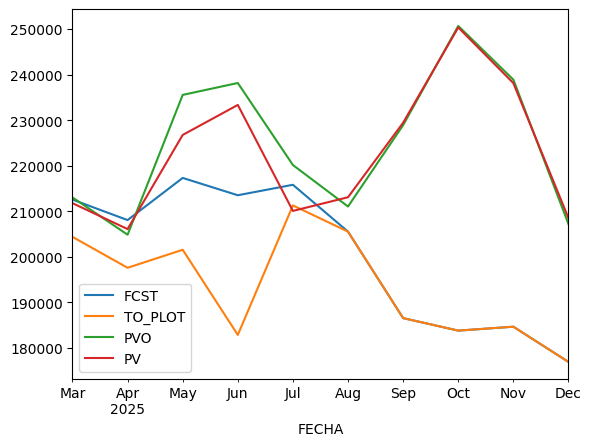

In [120]:
df[(df.MAX_MODEL == True) & (df.FECHA > "2025-02-03")].groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"}).plot()

In [121]:
condiciones = [df["MAX_Modelo"] == col  for col in cols2mape]

valores = [df[col]  for col in cols2mape]

# Valores a imputar según condiciones

df['FCST'] = np.select(condiciones, valores, default=None)

df["TO_PLOT"] = np.where(df.Segmento == 'Validacion', df["FACT"], df["FCST"])

In [122]:
df_2 = pd.read_excel(r"C:\Users\adojeda\Downloads\MejorPronostico2025-07-02.xlsx")

COLS2MAPE = df_2.columns[df_2.columns.str.contains("AVG_MAPE_")]

COLS2MAPE = [i.split("_")[-1] for i in COLS2MAPE]

condiciones = [df_2["MAX_Modelo"] == col  for col in COLS2MAPE]

valores = [df_2[col]  for col in COLS2MAPE]

# Valores a imputar según condiciones

df_2['FCST'] = np.select(condiciones, valores, default=None)

df_2["TO_PLOT"] = np.where(df_2.Segmento == 'Validacion',df_2["FACT"], df_2["FCST"])

In [123]:
df_2[df_2.FECHA.dt.year == 2025].groupby(["FECHA","Segmento"]).agg({"FCST":"sum", "TO_PLOT":"sum"})

,,FCST,TO_PLOT
FECHA,Segmento,,
2025-01-01,Validacion,397797.371353,337579.820904
2025-02-01,Validacion,391052.664619,320410.55912
2025-03-01,Validacion,367188.253691,297143.962961
2025-04-01,Pronostico,360011.378652,360011.378652
2025-05-01,Pronostico,363936.243624,363936.243624
2025-06-01,Pronostico,211168.434913,211168.434913
2025-07-01,Pronostico,210346.477006,210346.477006
2025-08-01,Pronostico,207044.570856,207044.570856
2025-09-01,Pronostico,215365.616653,215365.616653


In [124]:
df.groupby("FECHA").agg({"FCST":"sum", "TO_PLOT":"sum", "PVO":"sum", "PV":"sum"})

,FCST,TO_PLOT,PVO,PV
FECHA,,,,
2025-02-01,379708.435257,342845.162388,298645.26291,288215.995480
2025-03-01,332081.099546,314307.60376,283287.80707,280563.115520
2025-04-01,312485.821204,287746.868562,267645.11609,269507.289160
2025-05-01,336147.079242,300438.61289,314273.67653,315664.116740
2025-06-01,329615.279967,279451.11279,316633.67032,310904.255010
2025-07-01,339408.410151,317042.265877,287276.35139,278331.420300
2025-08-01,327901.310059,327901.310059,279007.84376,276578.383510
2025-09-01,260913.488146,260913.488146,321046.08538,325518.982720
2025-10-01,242193.274857,242193.274857,327597.20421,330626.805088
